In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, WhiteKernel
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss

from scipy.stats import zscore, log_loss

np.random.seed(1)

combo = pd.read_csv('2016-2017_combo.csv')
df = pd.read_excel('cts.xlsx', sheet_name='2016-2017')
to_keep = ['Team Name', 'Adj Off Efficiency', 'Adj Off-Def', 'Adj Def Efficiency', 'FG%',#, 'Strength of Schedule', #'Avg. Scoring margin',
           'Rebounds', 'Wins Last 10 Games ', 'Turnovers per game ', 'Coach Record']
df = df[to_keep]
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].apply(zscore)

In [48]:
Xs = []
ys = []

for idx, row in combo.iterrows():
    winner = row['Winner']
    loser = row['Loser']

    w_v = np.array(df[df['Team Name'] == winner])[0][1:]
    l_v = np.array(df[df['Team Name'] == loser])[0][1:]

    Xs.append(np.array([w_v, l_v]).flatten())
    ys.append(np.array([row['Winner Points'] - row['Loser points']]))
    
    Xs.append(np.array([l_v, w_v]).flatten())
    ys.append(np.array([row['Loser points'] - row['Winner Points']]))

X = np.array(Xs)
y = np.array(ys)

coval = pd.read_csv('2015-2016_combo.csv')
val = pd.read_excel('cts.xlsx', sheet_name='2015-2016')
val = val[to_keep]
numeric_cols = val.select_dtypes(include=[np.number]).columns
val[numeric_cols] = val[numeric_cols].apply(zscore)

Xvs = []
yvs = []

for idx, row in coval.iterrows():
    winner = row['Winner']
    loser = row['Loser']
    
    try:
        w_v = np.array(val[val['Team Name'] == winner])[0][1:]
        l_v = np.array(val[val['Team Name'] == loser])[0][1:]
        Xvs.append(np.array([w_v, l_v]).flatten())
        yvs.append(np.array([row['Winner Points'] - row['Loser points']]))
        
        Xvs.append(np.array([l_v, w_v]).flatten())
        yvs.append(np.array([row['Loser points'] - row['Winner Points']]))
    except:
        print(winner)
        print(loser)

Xv = np.array(Xvs)
yv = np.array(yvs)

Syracuse
MTSU
MTSU
Michigan State


In [49]:
rep = -1000
rbest_ = 0
obest_ = 0
wbest_ = 0

rbest = 57.89515789473683
obest = 26.31652631578947
wbest = 78.7878788090909

print('starting')
count=0
for rbf_val in np.linspace(rbest - 10, rbest + 10, 10):
    for outside in np.linspace(obest - 10, obest + 10, 10):
        for wkb in np.linspace(wbest - 10, wbest + 10, 10):
            kernel = outside * RBF(rbf_val) + WhiteKernel(wkb)    
            gp = GaussianProcessRegressor(kernel,
                                          n_restarts_optimizer=10,
                                          normalize_y=True)
            gp.fit(X, y)
            score = gp.score(Xv, yv)
            if score > rep:
                rbest_ = rbf_val
                obest_ = outside
                wbest_ = wkb
                rep = score
            
            count += 1
            if count % int(10*10*10/100) == 0:
                print(f'{count / (10*10*10)}')
                
print('GP Validation R^2: ' + str(rep))
print(f'Best RBF Length Scale: {rbest_}')
print(f'Best RBF Kernel Scale: {obest_}')
print(f'Best White Noise: {wbest_}')

starting
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
1.0
GP Validation R^2: 0.34648838295285145
Best RBF Length Scale: 56.78404678362572
Best RBF Kernel Scale: 16.31652631578947
Best White Noise: 82.12121214242423


In [51]:
kernel = obest_ * RBF(rbest_) + WhiteKernel(wbest_)
gp = GaussianProcessRegressor(kernel,
                                  n_restarts_optimizer=10,
                                  normalize_y=True)
gp.fit(X, y)
rep = gp.score(Xv, yv)

print('GP Validation R^2: ' + str(rep))

GP Validation R^2: 0.3464881570473396


In [52]:
lm = linear_model.LinearRegression(fit_intercept=False, normalize=True)
lm.fit(X, y)
lm.score(Xv, yv)

0.36253004000895306

In [53]:
gp_y_pred = []
lm_y_pred = []
gp_sd = []
tys = []
for idx, row in coval.iterrows():
    winner = row['Winner']
    loser = row['Loser']
    
    try:
        w_v = np.array(val[val['Team Name'] == winner])[0][1:]
        l_v = np.array(val[val['Team Name'] == loser])[0][1:]
        Xvs.append(np.array([w_v, l_v]).flatten())
        yvs.append(np.array([row['Winner Points'] - row['Loser points']]))

        gp_y_pred_, gp_sd_ = gp.predict(np.array([w_v, l_v]).flatten().reshape(1, -1), return_std=True)
        gp_y_pred.append(gp_y_pred_)
        gp_sd.append(gp_sd_)
        lm_y_pred.append(lm.predict(np.array([w_v, l_v]).flatten().reshape(1, -1)))
        tys.append(row['Winner Points'] - row['Loser points'])
    except:
        print(winner)
        print(loser)

gp_y_pred=np.array(gp_y_pred).flatten()
lm_y_pred=np.array(lm_y_pred).flatten()
gp_sd = np.array(gp_sd).flatten()
tys = np.array(tys).flatten()

Syracuse
MTSU
MTSU
Michigan State


(array([ 1.,  4., 11., 16.,  5., 16.,  1.,  4.,  1.,  2.]),
 array([-7.1620883 , -5.54489204, -3.92769579, -2.31049953, -0.69330328,
         0.92389298,  2.54108924,  4.15828549,  5.77548175,  7.39267801,
         9.00987426]),
 <a list of 10 Patch objects>)

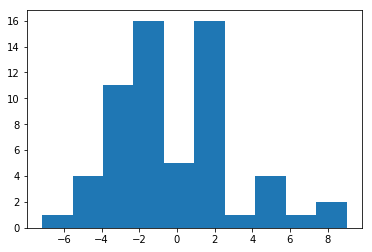

In [54]:
plt.hist(gp_y_pred - lm_y_pred)

(array([ 1.,  0.,  0.,  0.,  5.,  9., 14., 18., 10.,  4.]),
 array([-51.12921388, -44.99560596, -38.86199804, -32.72839012,
        -26.5947822 , -20.46117428, -14.32756636,  -8.19395844,
         -2.06035052,   4.0732574 ,  10.20686532]),
 <a list of 10 Patch objects>)

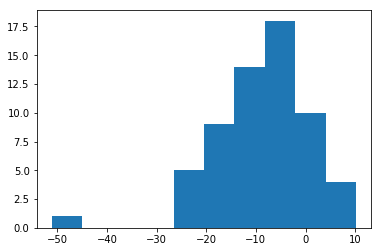

In [55]:
plt.hist(gp_y_pred - tys)

(array([ 1.,  0.,  0.,  0.,  6.,  6., 11., 19.,  8., 10.]),
 array([-47.21086157, -41.86709908, -36.52333659, -31.1795741 ,
        -25.83581161, -20.49204912, -15.14828664,  -9.80452415,
         -4.46076166,   0.88300083,   6.22676332]),
 <a list of 10 Patch objects>)

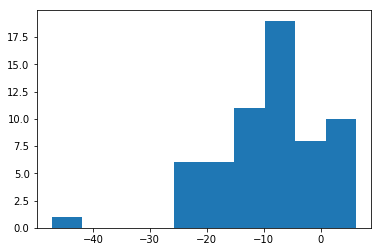

In [56]:
plt.hist(lm_y_pred - tys)

In [57]:
correct = 0
for i in range(len(tys)):
    if tys[i] >= 0:
        if lm_y_pred[i] >= 0:
            correct += 1
    else:
        if lm_y_pred[i] < 0:
            correct += 1
            
print(correct/len(tys))

0.6557377049180327


In [58]:
correct = 0
for i in range(len(tys)):
    if tys[i] >= 0:
        if gp_y_pred[i] >= 0:
            correct += 1
    else:
        if gp_y_pred[i] < 0:
            correct += 1
            
print(correct/len(tys))

0.6721311475409836


In [71]:
y_pred_probs = 1 - norm.cdf(-gp_y_pred / gp_sd)
log_loss(np.array(tys > 0, dtype=np.int), np.array([1 - y_pred_probs, y_pred_probs]).T, labels=[0, 1])

0.6042594966508172